## import packages

In [1]:
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML


from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

# Widgets import
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import copy

### import functions from library
from codes import helper

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
vehicles = glob.glob('./data/vehicles/*/*.png')
non_vehicles = glob.glob('./data/non-vehicles/*/*.png')

print("Number of vehicles images: ", len(vehicles))
print("Number of non-vehicles images: ", len(non_vehicles))

Number of vehicles images:  8792
Number of non-vehicles images:  8968


## Check out the images

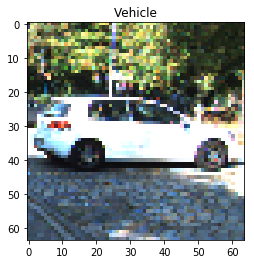

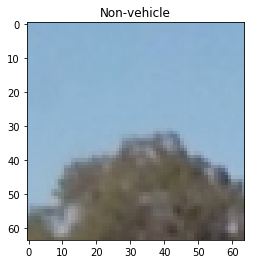

In [3]:
car_image = mpimg.imread(vehicles[ np.random.randint(0, len(vehicles))])
notcar_image = mpimg.imread(non_vehicles[np.random.randint(0, len(non_vehicles))])


plt.figure()
plt.imshow(car_image)
plt.title("Vehicle")

plt.figure()
plt.imshow(notcar_image)
plt.title("Non-vehicle")


## Try out hog using a specific params

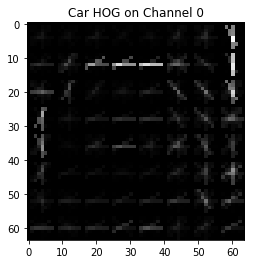

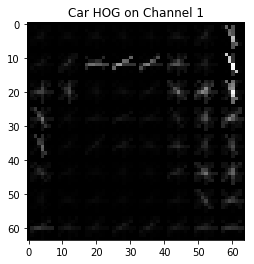

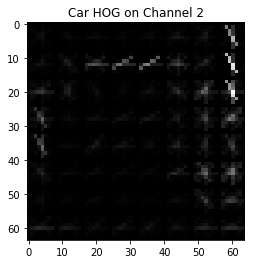

In [46]:
features, img_output = helper.extract_features_hog(car_image, cspace='YCrCb', orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
for i, img_ in enumerate(img_output):
    plt.figure()
    plt.imshow(img_, cmap='gray')
    plt.title("Car HOG on Channel {}".format(i))

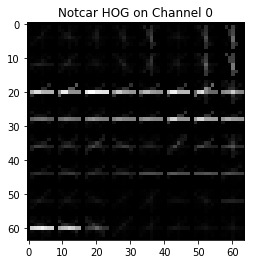

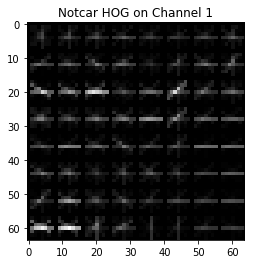

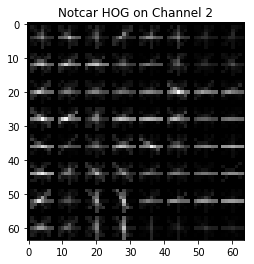

In [47]:
features, img_output = helper.extract_features_hog(notcar_image, cspace='YCrCb', orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
for i, img_ in enumerate(img_output):
    plt.figure()
    plt.imshow(img_, cmap='gray')
    plt.title("Notcar HOG on Channel {}".format(i))

### Tune the hog parameters

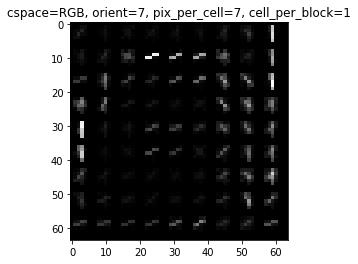

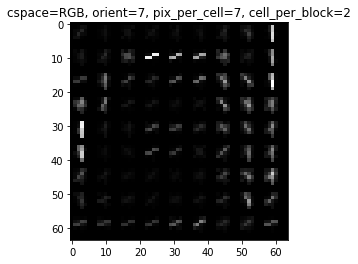

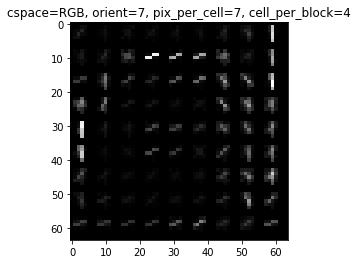

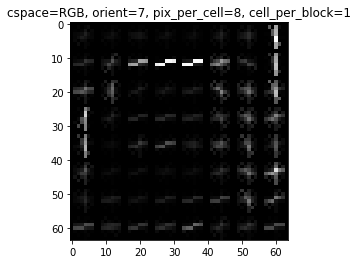

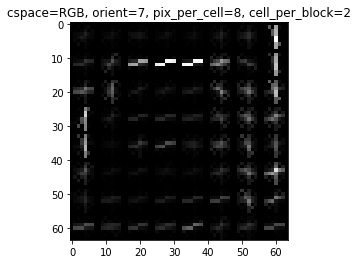

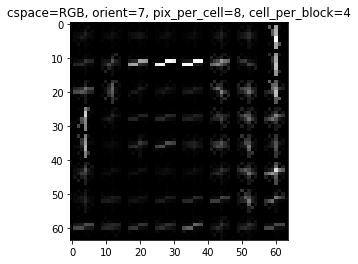

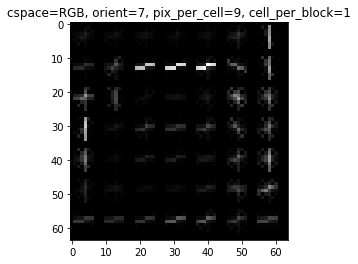

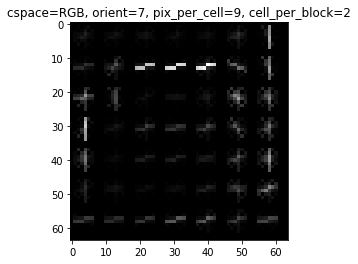

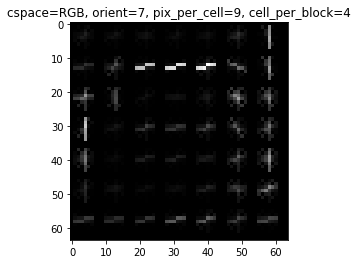

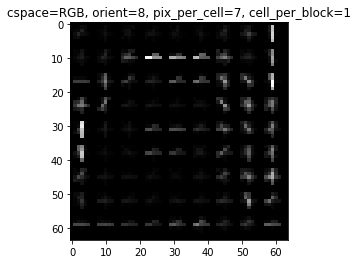

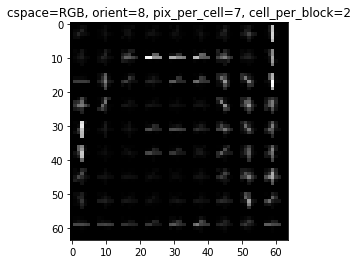

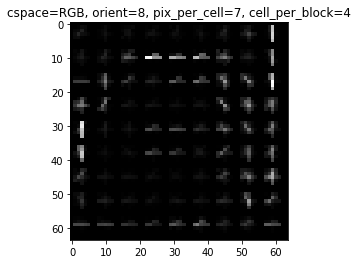

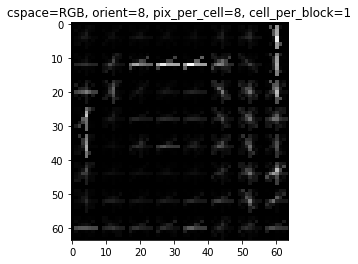

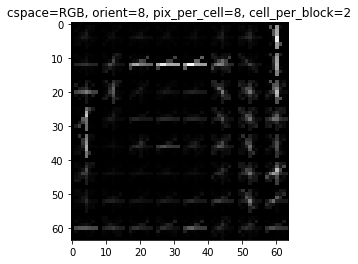

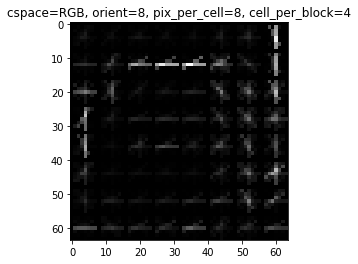

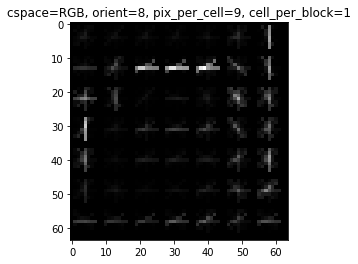

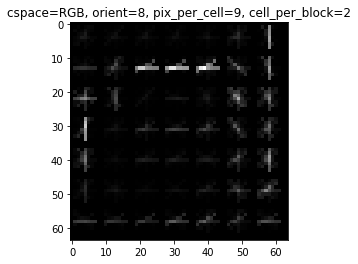

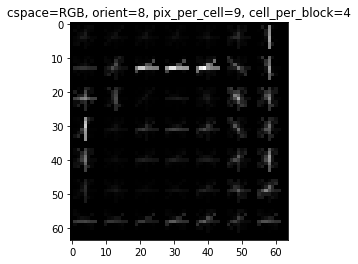

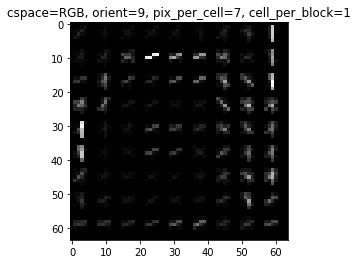

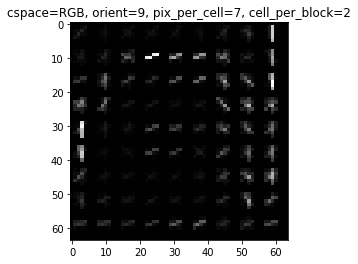

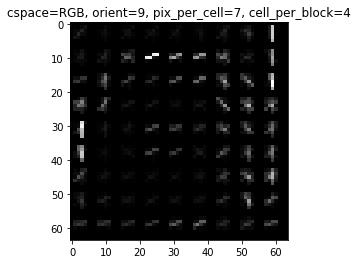

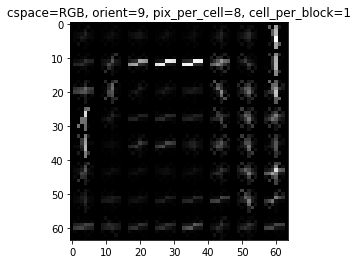

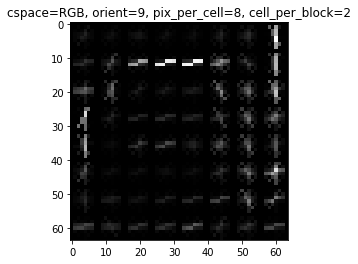

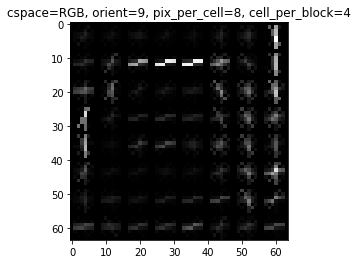

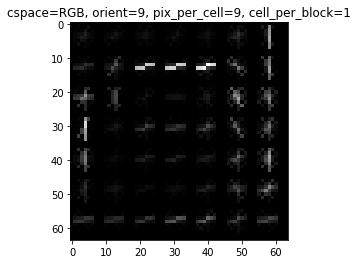

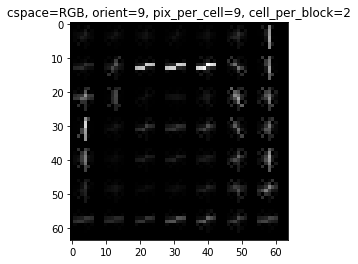

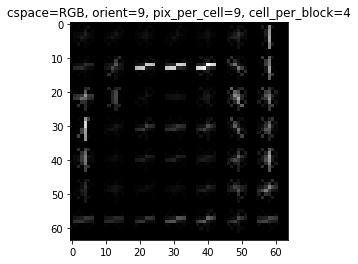

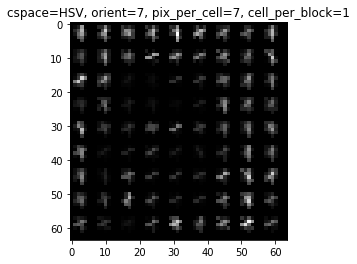

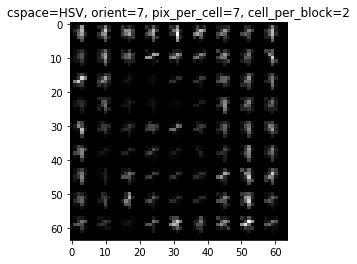

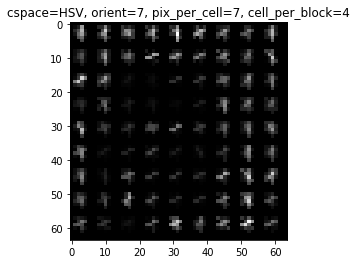

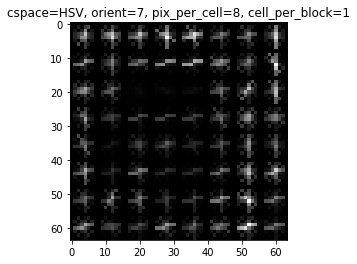

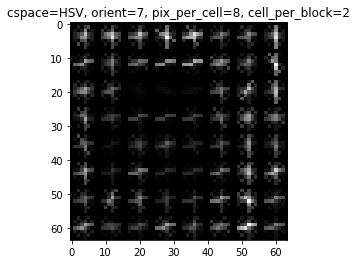

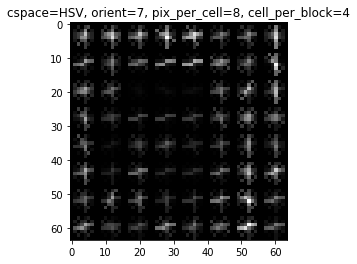

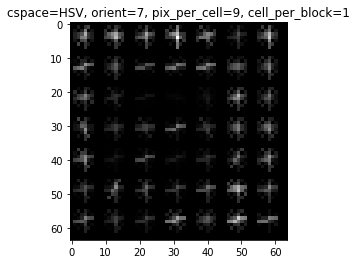

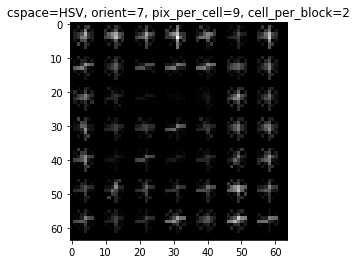

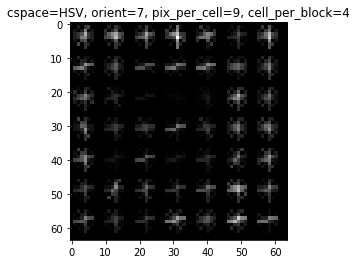

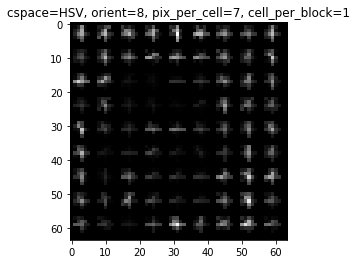

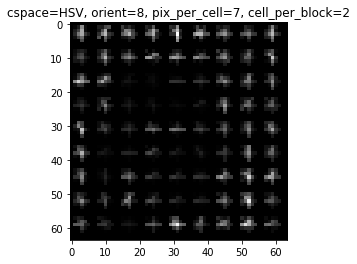

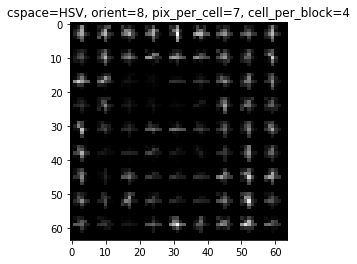

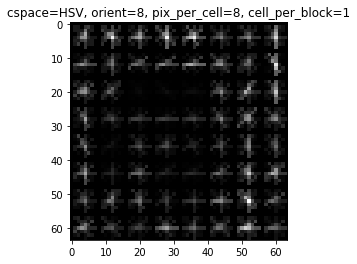

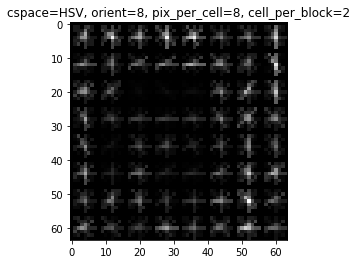

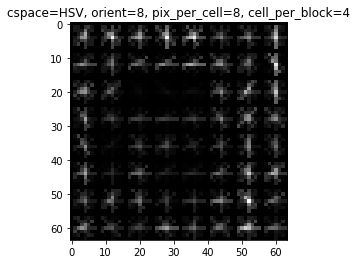

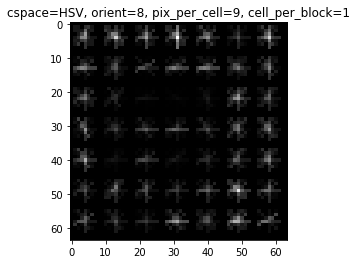

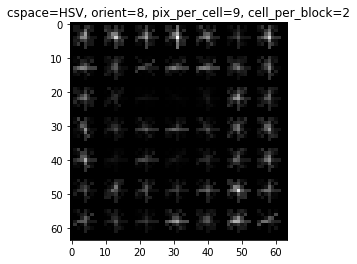

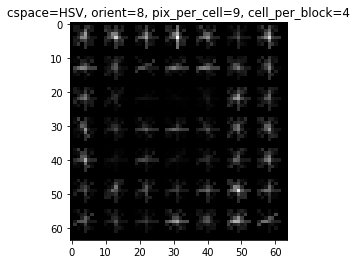

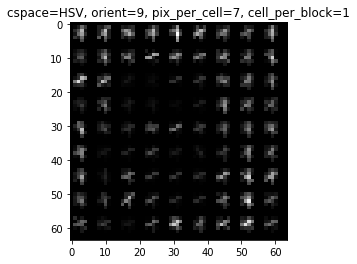

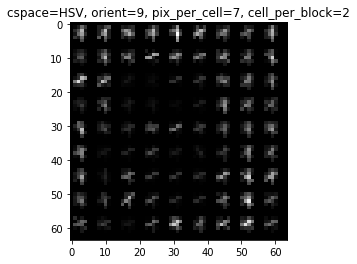

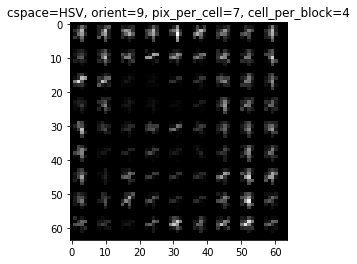

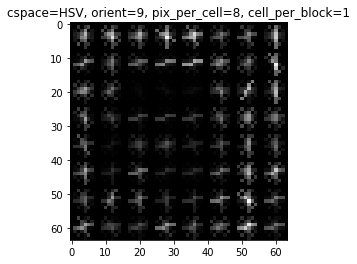

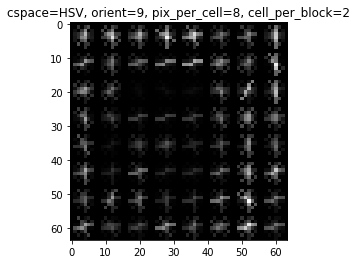

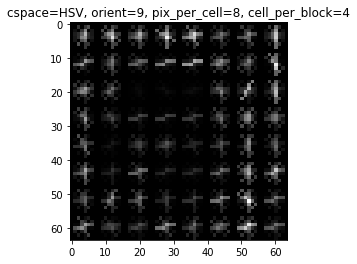

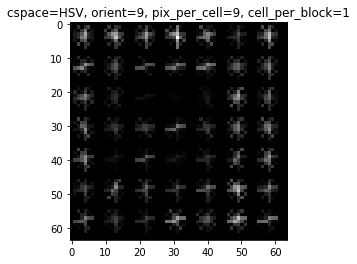

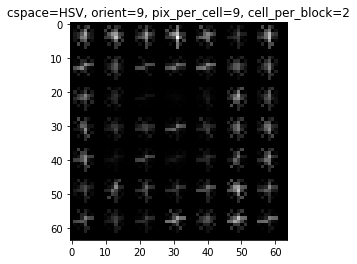

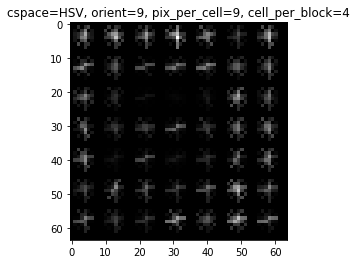

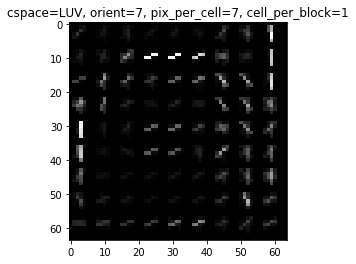

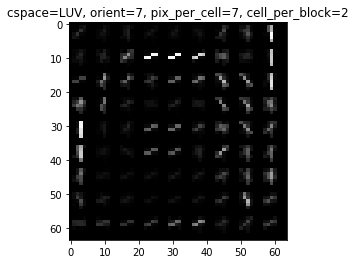

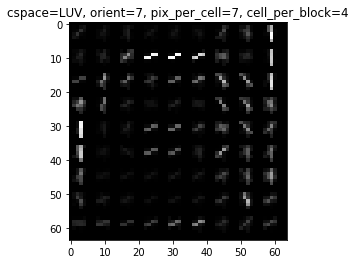

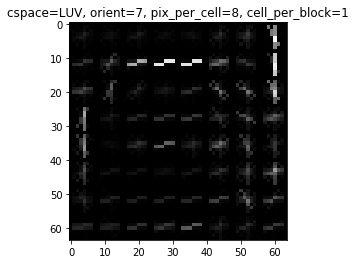

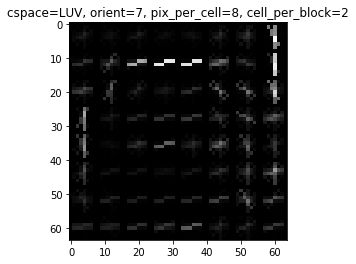

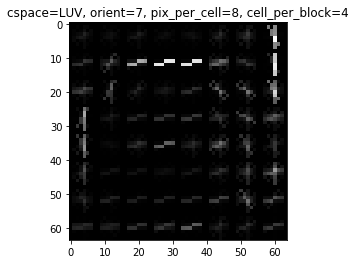

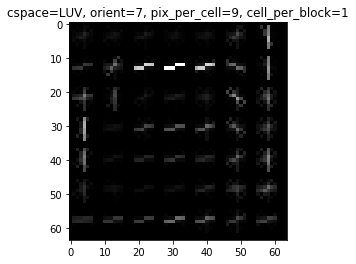

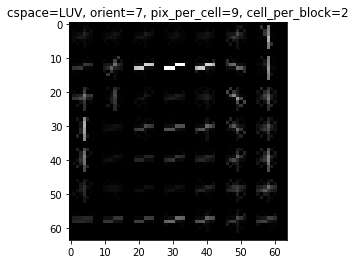

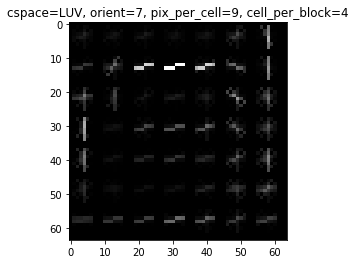

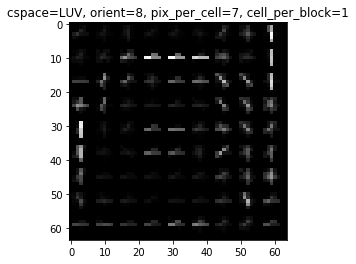

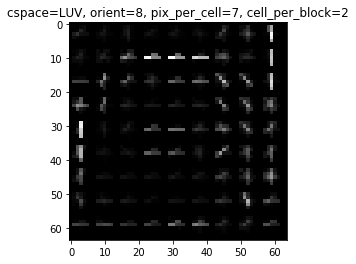

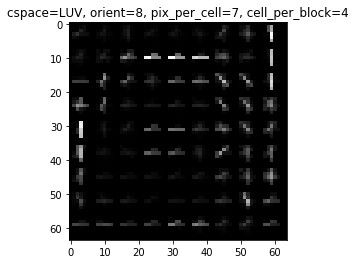

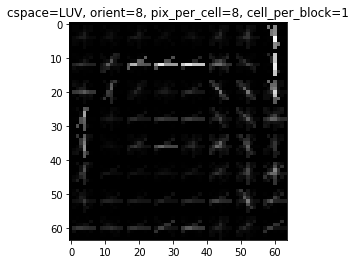

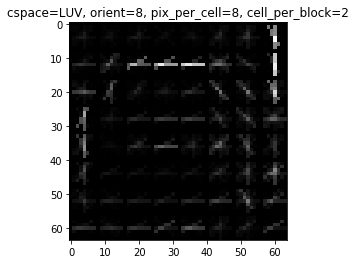

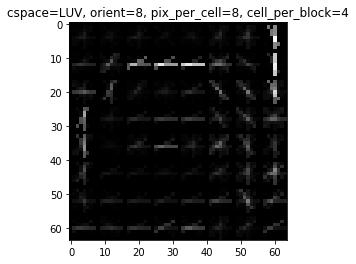

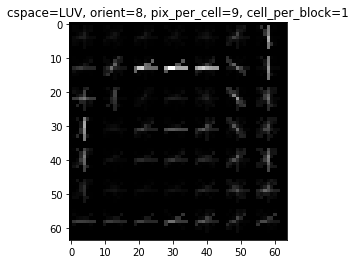

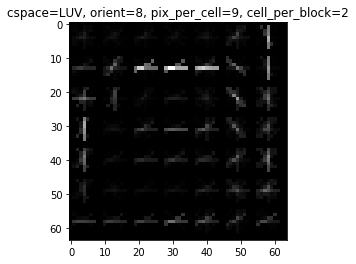

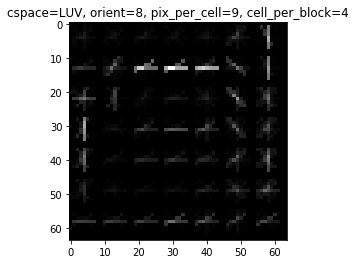

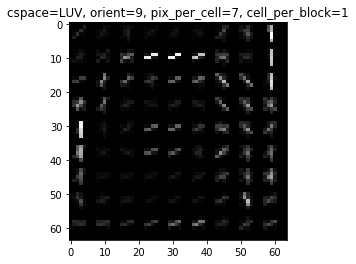

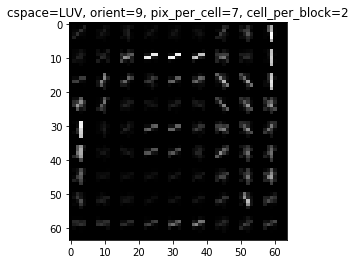

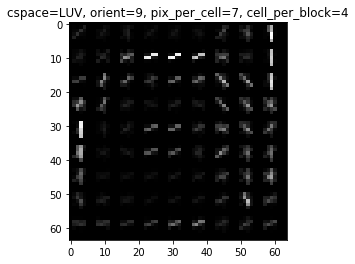

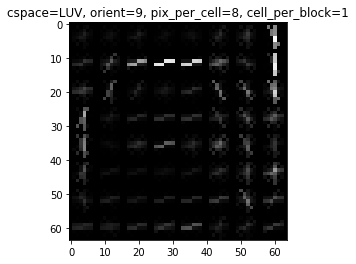

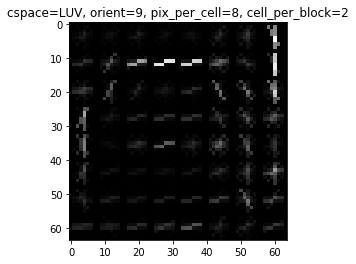

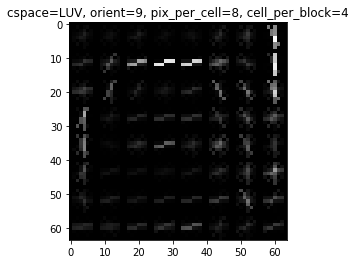

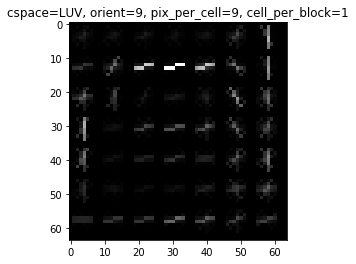

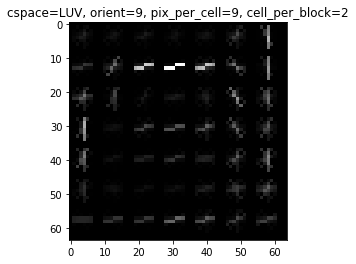

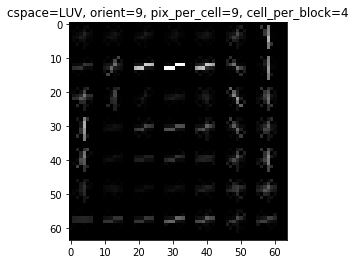

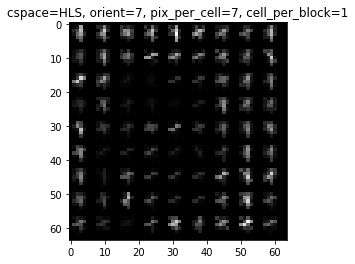

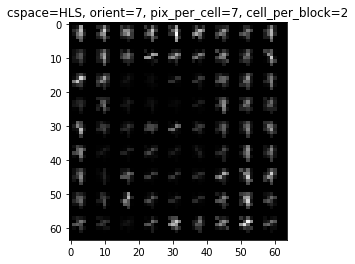

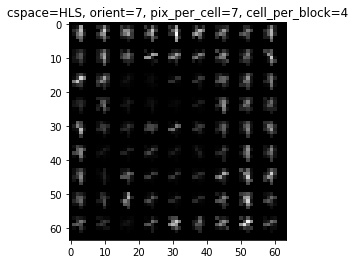

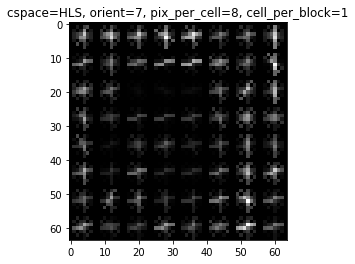

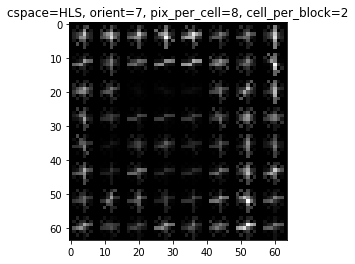

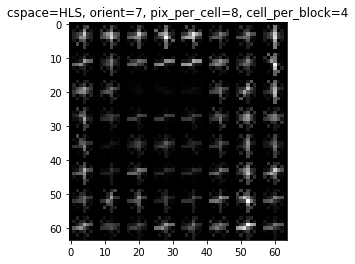

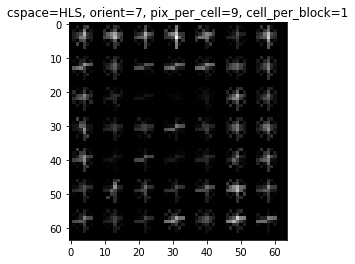

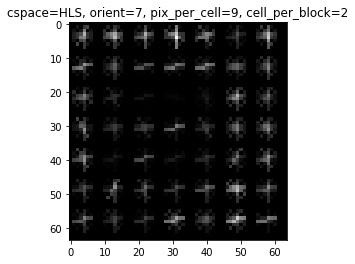

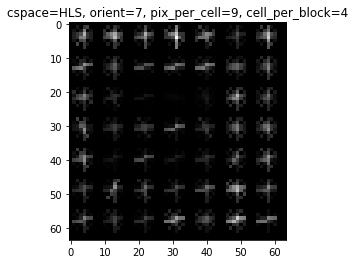

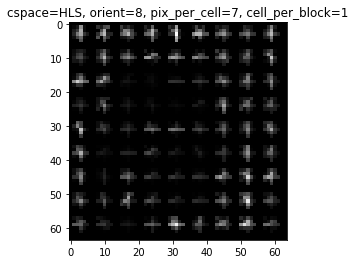

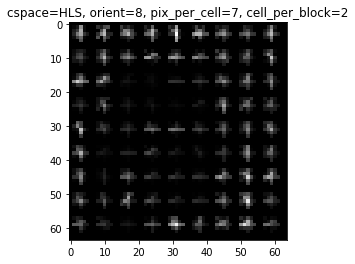

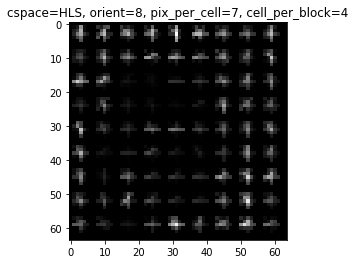

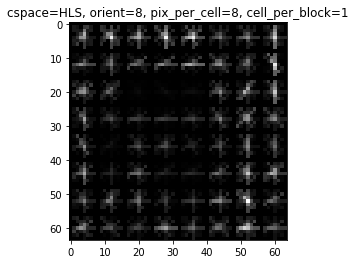

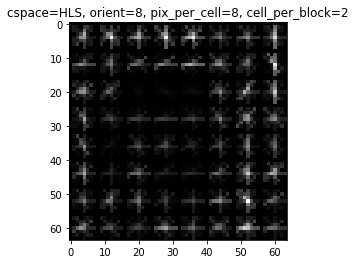

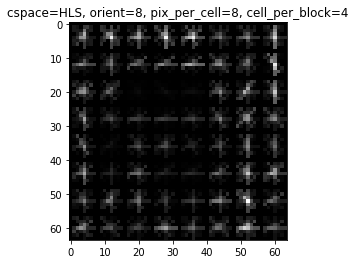

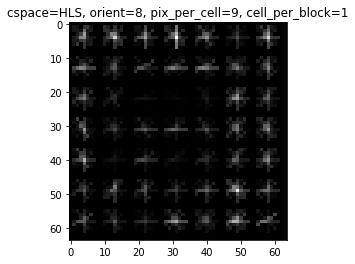

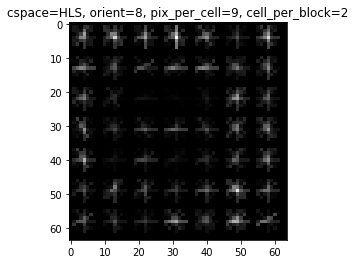

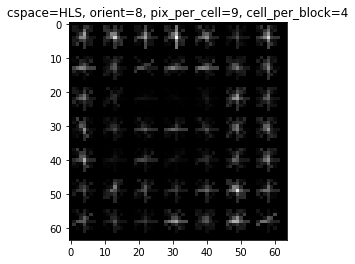

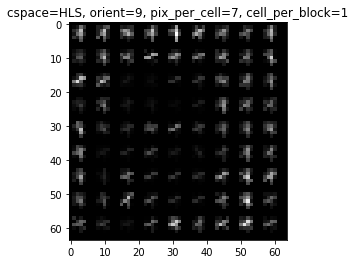

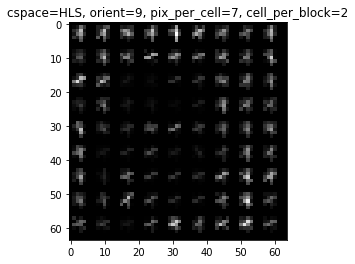

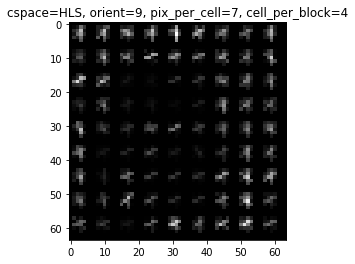

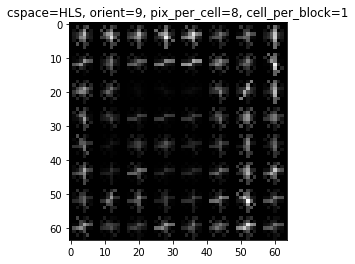

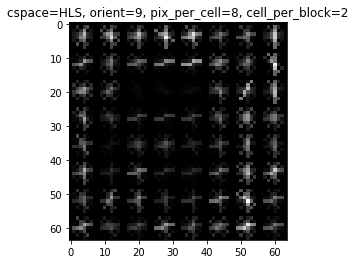

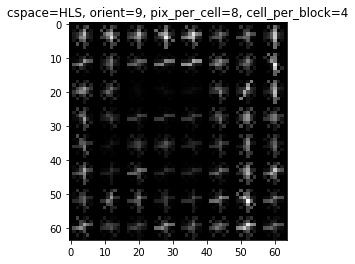

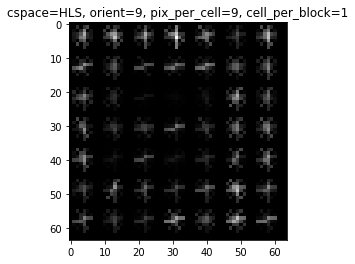

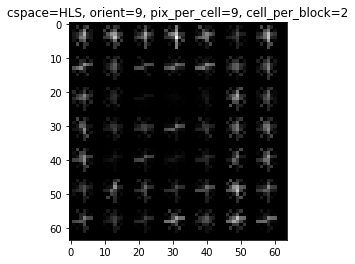

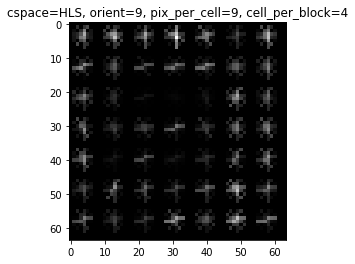

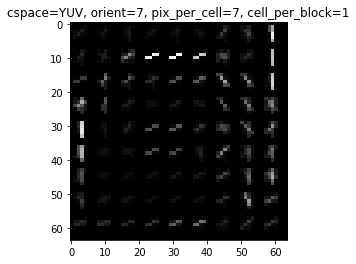

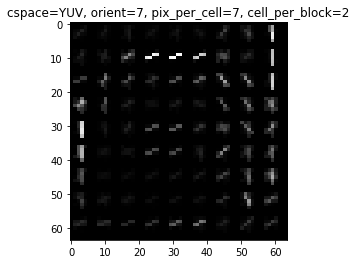

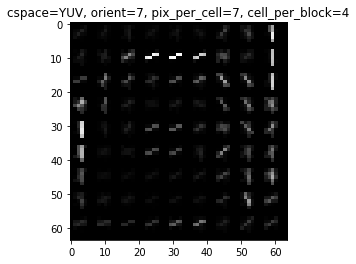

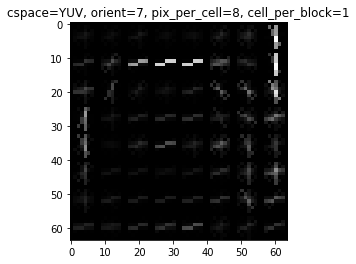

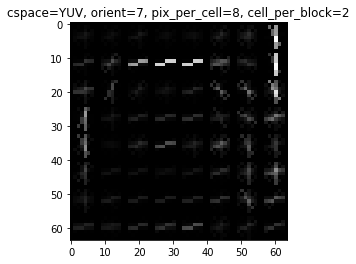

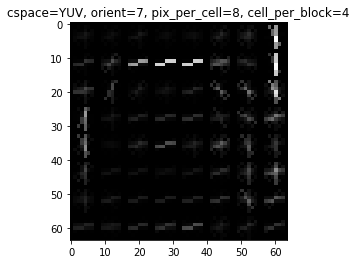

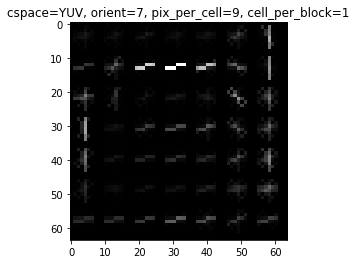

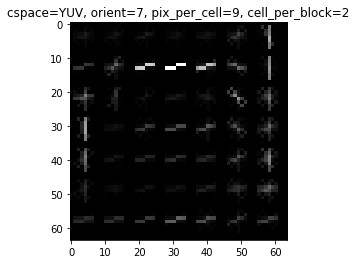

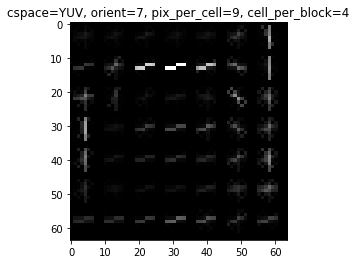

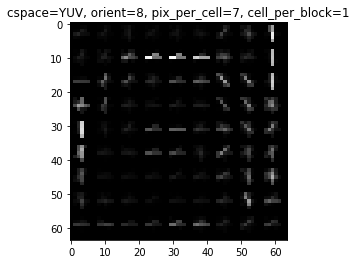

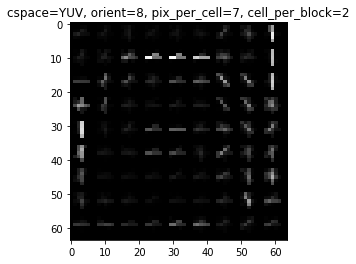

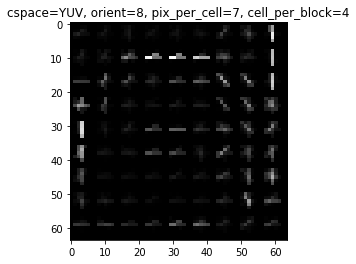

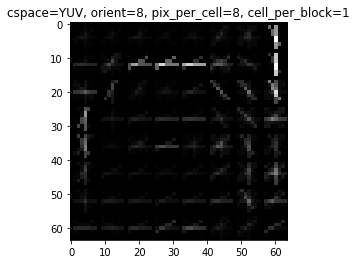

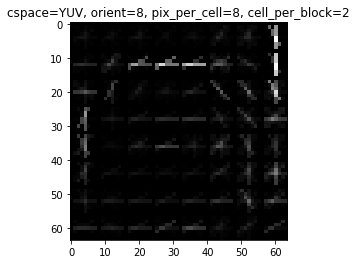

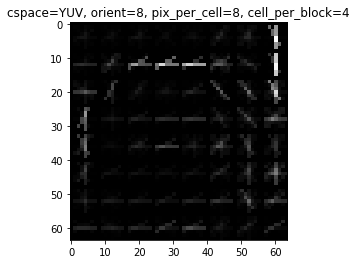

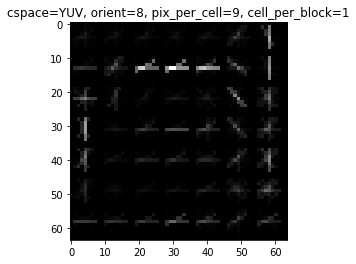

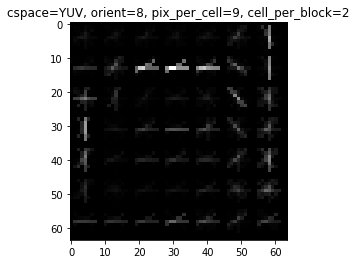

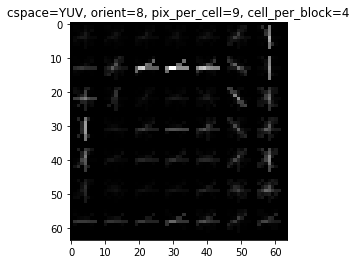

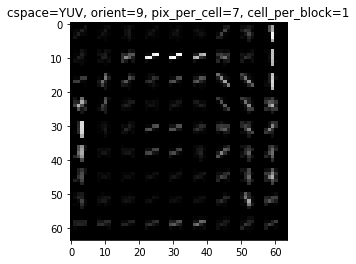

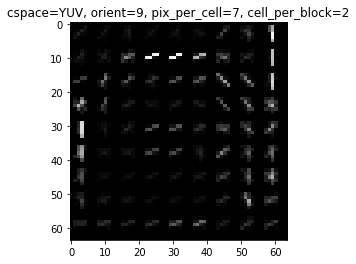

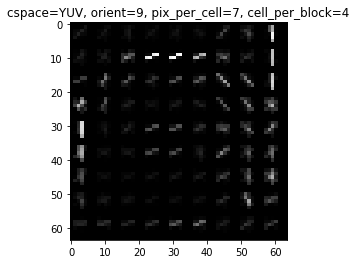

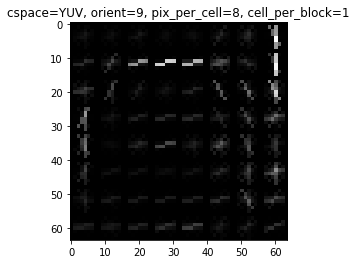

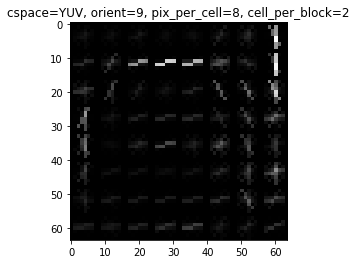

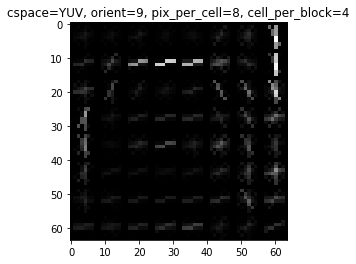

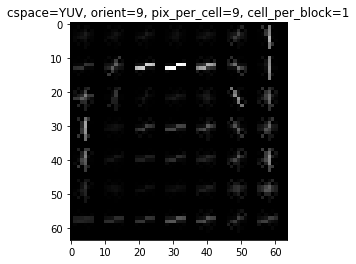

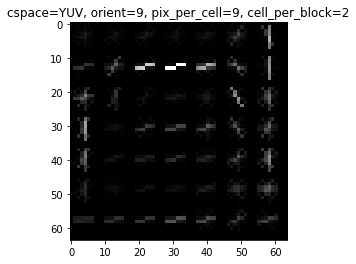

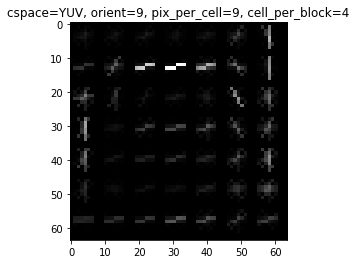

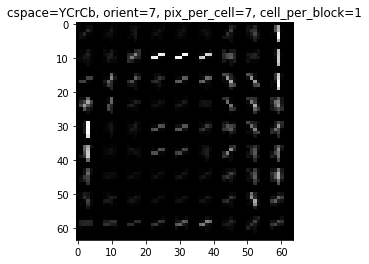

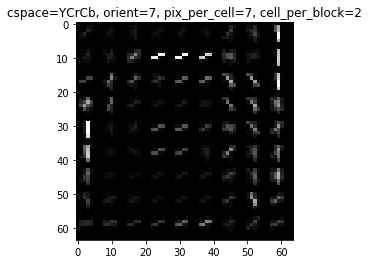

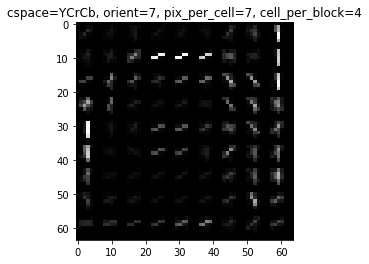

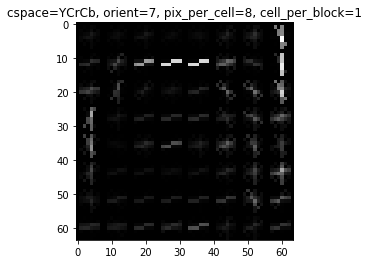

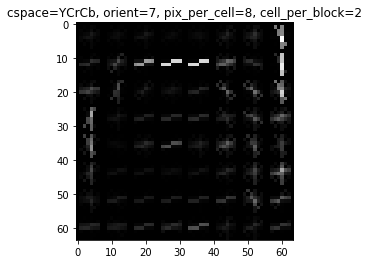

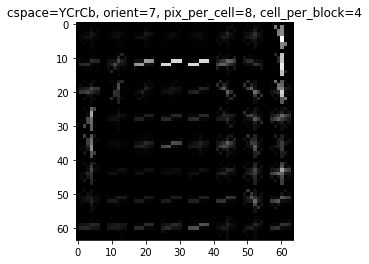

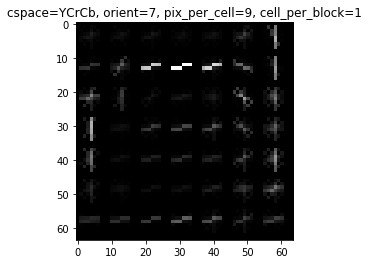

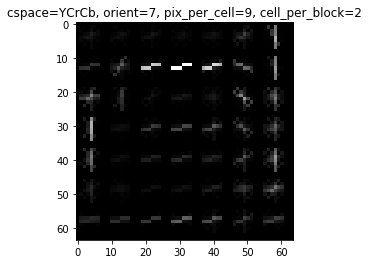

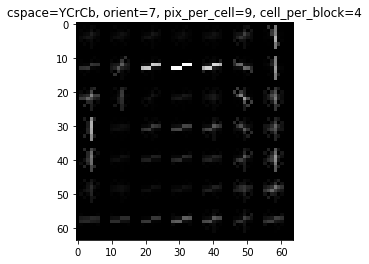

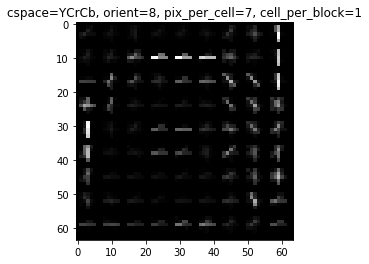

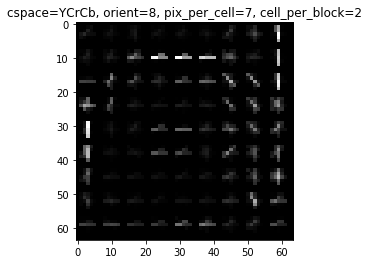

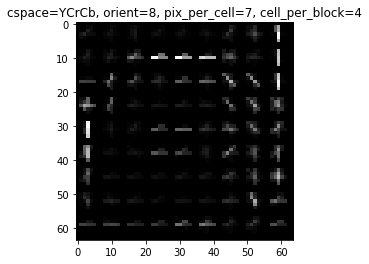

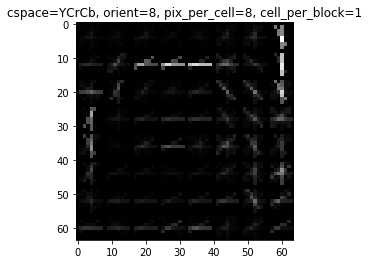

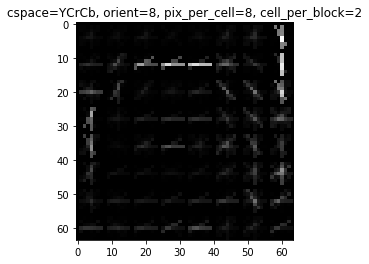

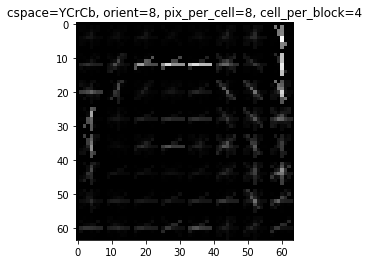

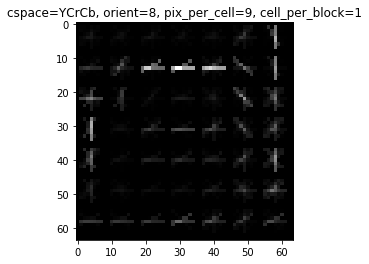

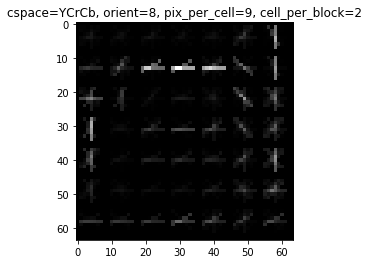

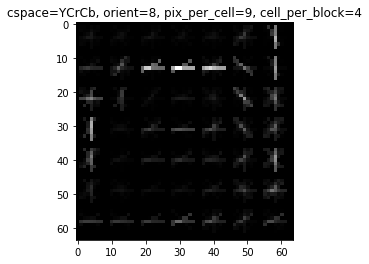

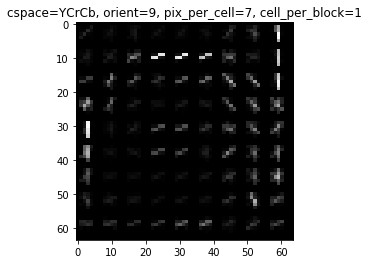

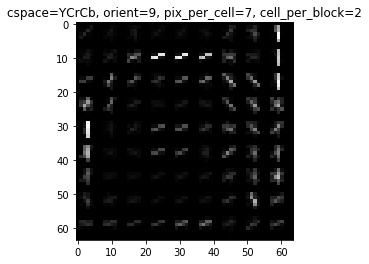

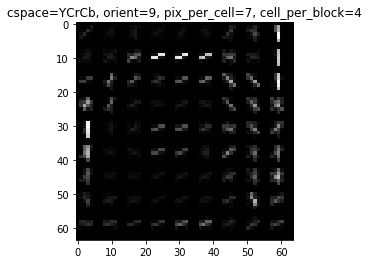

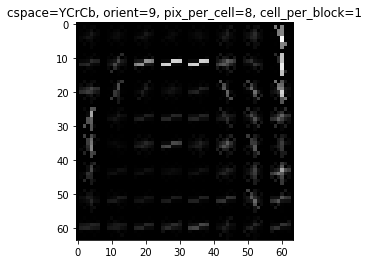

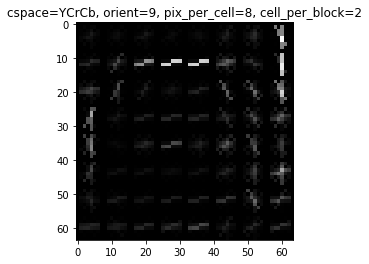

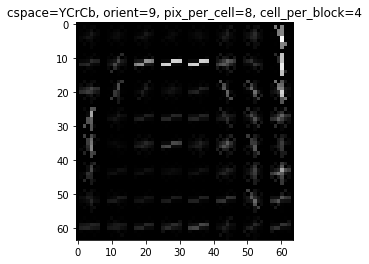

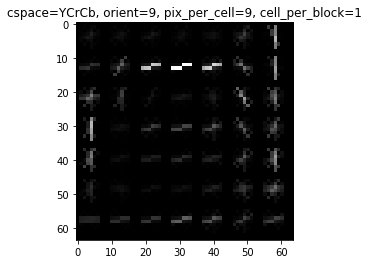

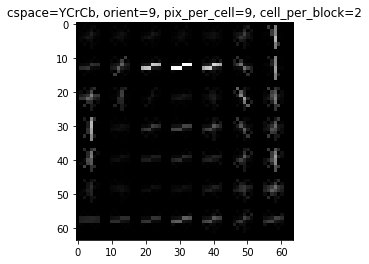

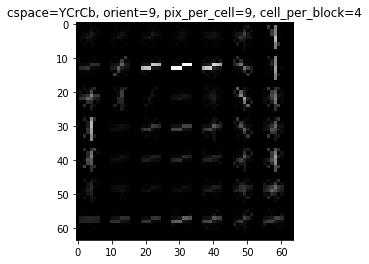

In [53]:
cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orients = [7, 8, 9]
pix_per_cells = [7, 8, 9]
cell_per_blocks = [1, 2, 4]

for cspace in cspaces:
    for orient in orients:
        for pix_per_cell in pix_per_cells:
            for cell_per_block in cell_per_blocks:
                features, img_output = helper.extract_features_hog(car_image, cspace=cspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=0)
                plt.figure()
                plt.imshow(img_output[0], cmap='gray')
                plt.title("cspace={}, orient={}, pix_per_cell={}, cell_per_block={}"
                          .format(cspace, orient, pix_per_cell, cell_per_block))
            

## Final Parameters:

In [4]:
debug = False


params = {
    # HOG
    "cspace": 'YCrCb',
    "orient": 0,
    "orient": 9,  
    "pix_per_cell": 8 ,
    "cell_per_block": 2,
    "hog_channel": 'ALL',

    # Spatial and histogram params
    "spatial_size": (32, 32), # Spatial binning dimensions
    "hist_nbins": 32,    # Number of histogram bins

    # what feature we use
    "use_hog": True,
    "use_spatial": True,
    "use_hist": True,
}


if debug:
    vehicles_to_train = vehicles[0:100]
    non_vehicles_to_train = non_vehicles[0:100]
else:
    vehicles_to_train = vehicles
    non_vehicles_to_train = non_vehicles

## Prepare X and Y

In [ ]:
t=time.time()

vehicles_features = helper.extract_images_features(imgs = vehicles_to_train, **params)
non_vehicles_features = helper.extract_images_features(imgs = non_vehicles_to_train, **params)

t2 = time.time()
print("Extraction time: {}s".format(round(t2-t, 2)))

X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)     
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## Train SVM

In [78]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)


print('Training Classifier')
print('Using:', orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("Training time: {}".format(round(t2-t, 2)))
    
# Check the score of the SVC
print('Test Accuracy: {}'.format(round(svc.score(X_test, y_test), 3)))

joblib.dump(svc, "./saved_model/svc.pkl")

Training Classifier
Using: 9 orientations 9 pixels per cell and 4 cells per block
Feature vector length: 8460
Training time: 0.09
Test Accuracy: 1.0
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  1.  0.  1.  0.]
0.00623 Seconds to predict 10 labels with SVC


['./saved_model/svc.pkl']

## Sliding Window Search